In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.stats import circmean, circstd, mode

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
import taylorDiagram

from numpy.fft import fft, ifft
import astropy.stats.circstats as astro_circstats

import diurnal_config

from diurnal_utils import *
from fetch_model_helper import *
import dask.dataframe as dd

%run cmip_metrics.py
%run model_by_model_analysis_helper.py

import matplotlib 

font = {'weight' : 'bold',
        'size'   : 13}
label_fontdict = {'weight' : 'bold',
        'size'   : 13}
title_fontdict = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

FLUX_TO_MM_HR = 60*60
MM_HR_TO_MM_DAY = 24.0
MM_HR_TO_MM_YR = 24*365
FLUX_TO_MM_YR = FLUX_TO_MM_HR*MM_HR_TO_MM_YR

HOURS_TO_RADIANS = 2*np.pi/24


In [124]:
rel_data_dir = '/export/data1/cchristo/'
save_figs_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/'
save_figs_dir_paper = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/paper/'
save_fig_dir_update = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/tapio_update_9_10/'
##### open cmip5
# input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5_regridded/grid1/' #GFDL-ESM2M/'
input_data_dir_cm5  = rel_data_dir + 'diurnal_analysis_results/CMIP5_bin_pt2_hr_round_regridded/grid1/'

#### open cmip6
# input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_regridded/grid1/' #GFDL-ESM4/'
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_bin_pt2_hr_round_regridded/grid1/' #GFDL-ESM4/'
# input_data_dir_cm6 = rel_data_dir + 'diurnal_analysis_results/CMIP6_clt_regridded/grid1/'

input_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results//GPM_bin_pt2_hr_15_yr_regridded/grid1/GPM_bin_pt2_hr_15_yr/'
land_sea_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/grid1/grid1_GLDASp4_landmask_1d.nc'


# paths to mean climate fields 



input_data_dir_rlut = rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/'
input_data_dir_rsut = rel_data_dir + 'CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/' 
input_data_dir_pr = rel_data_dir + 'CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/'
input_data_dir_clt = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/' 
input_data_dir_cltl = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/cltl_regridded/grid1/' 
input_data_dir_clth = rel_data_dir + 'CMIP6_clouds/averages/time_averages/period/clth_regridded/grid1/' 
mean_fields_to_rel_path_map = {
    'rlut': input_data_dir_rlut,
    'rsut': input_data_dir_rsut,
    'pr': input_data_dir_pr,
    'clt':input_data_dir_clt,
    'cltl': input_data_dir_cltl,
    'clth': input_data_dir_clth,
}



In [3]:
rel_cmip6_path= '/export/data1/cchristo/CMIP6_clouds/clt_3hr_historical/'
rel_cmip5_path = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'

unique_cmip6_models = list(get_unique_models(rel_cmip6_path))
unique_cmip5_models = list(get_unique_models(rel_cmip5_path))

In [4]:

ds_land_sea = xr.open_dataset(land_sea_mask)
df_land_sea = ds_land_sea.to_dataframe().astype(int)
# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']




## Take mean accross seasons for GPM (circular for phase!)

In [76]:
# ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2016-06_precip.nc')

# ### compute means
# # # take mean across seasons using circular mean for phase
# ds_gpm_phase_year_mean = xr.apply_ufunc(phase_circmean, ds_gpm['phase_season'], 
# #                                    kwargs = {'low' : 0.0, 'high' : 24.0},
#                                    input_core_dims=[["season"]], 
#                                    vectorize = True)
# # compute yearly mean other data 
# ds_gpm = ds_gpm.mean(dim = 'season')
# ds_gpm['phase_season'] = ds_gpm_phase_year_mean

# #########

# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
# df_gpm = ds_gpm.to_dataframe()

# df_gpm_land = df_gpm[df_gpm['land_sea_mask'] == 1]
# df_gpm_water= df_gpm[df_gpm['land_sea_mask'] == 0]

In [293]:
ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2016-06_precip.nc')

### compute means
# # take mean across seasons using circular mean for phase
ds_gpm_phase_year_mean = xr.apply_ufunc(phase_circmean, ds_gpm['phase_season'], 
#                                    kwargs = {'low' : 0.0, 'high' : 24.0},
                                   input_core_dims=[["season"]], 
                                   vectorize = True)
# compute yearly mean other data 
ds_gpm = ds_gpm.mean(dim = 'season')
ds_gpm['phase_season'] = ds_gpm_phase_year_mean

#########

ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
df_gpm = ds_gpm.to_dataframe()

In [5]:
%run model_by_model_analysis_helper.py

df_gpm_seasonal = _open_and_preprocess_gpm(input_data_dir_gpm, ds_land_sea, False)
df_gpm = _open_and_preprocess_gpm(input_data_dir_gpm, ds_land_sea, True)



In [6]:
%%time
# # compute yearly mean
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = True,
                               verbose = False)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = 'grid1_1985-01_2006-01_precip.nc', 
                              compute_year_mean_bool = True,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,) #.reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df = pd.merge(df_models, df_land_sea, how = 'left', left_index = True, right_index = True)
# df = df.reset_index('season')
df = df.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

CPU times: user 6min 31s, sys: 4.42 s, total: 6min 36s
Wall time: 6min 46s


In [109]:
# df

In [256]:
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = False,
                               verbose = False)

df_cm6['cmip_identifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = 'grid1_1985-01_2006-01_precip.nc', 
                              compute_year_mean_bool = False,
                              verbose = False)
df_cm5['cmip_identifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,).reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df_seasonal = pd.merge(df_models, 
                       df_land_sea, 
                       how = 'left', 
                       left_index = True, 
                       right_index = True)
# df_seasonal = df_seasonal.reset_index('season')
df_seasonal = df_seasonal.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

In [80]:
# plt.savefig(‘test.pdf’, bbox_inches=‘tight’)

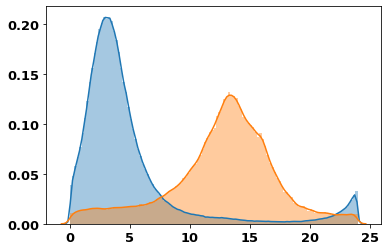

In [79]:
cmip_identifier = 'CMIP6'
field_id = 'phase_season'
nbins = 120
ax = None

df_water = df[(df['land_sea_mask'] == 0) & (df['cmip_identifier'] == cmip_identifier)] #[field_id]
df_land = df[(df['land_sea_mask'] == 1) & (df['cmip_identifier'] == cmip_identifier)] #[field_id]



sns.distplot(df_water[field_id].values , label = cmip_identifier + ' ' + 'Water', bins = nbins, ax = ax)
sns.distplot(df_land[field_id].values , label = cmip_identifier + ' ' + 'Land', bins = nbins, ax = ax)



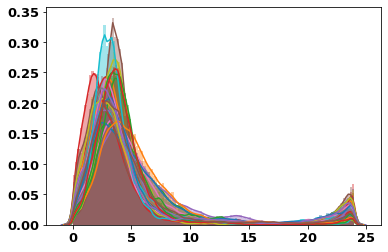

In [71]:
for model_name in df_water['model_name'].unique():
    sns.distplot(df_water[df_water['model_name'] == model_name][field_id].values , 
                 bins = nbins, 
                 ax = ax)



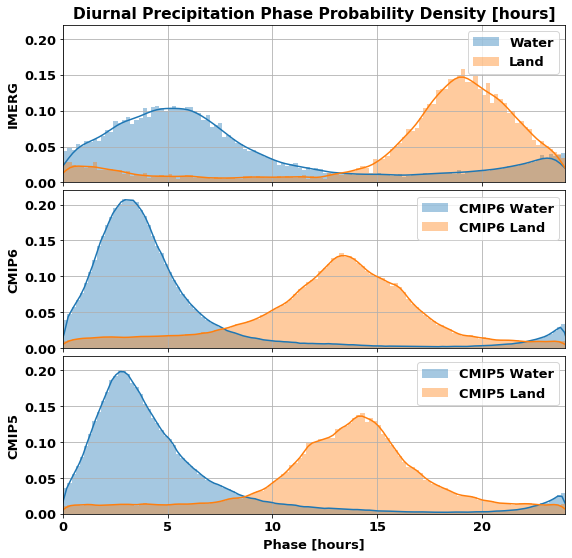

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [51]:
%run model_by_model_analysis_helper.py

fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))

land_sea_histogram(df_gpm, 
                   ax = ax_hist[0],
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG')

land_sea_histogram(df,
                   cmip_identifier= 'CMIP6',
                   ax = ax_hist[1],
                   ylabel = 'CMIP6')

land_sea_histogram(df,
                   cmip_identifier = 'CMIP5',
                   ax = ax_hist[2],
                   ylabel = 'CMIP5',
                   xlabel = 'Phase [Hour]')

fig.subplots_adjust(hspace=.05)

# fig.savefig(save_figs_dir_paper + 'yearly_histogram.png', dpi = 300)



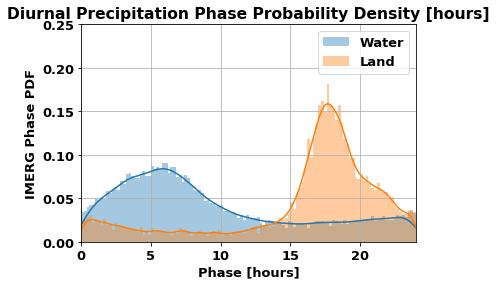

In [261]:
land_sea_histogram(filter_by_season(df_gpm, season_ii), 
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG Phase PDF')

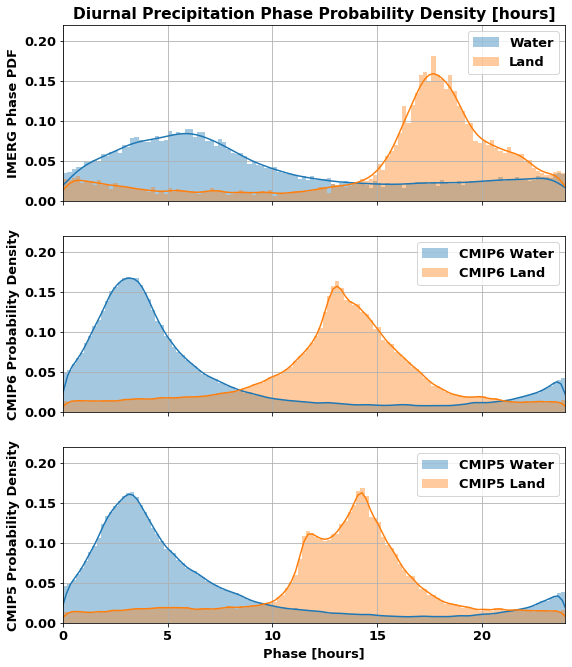

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [262]:
# land_sea_histogram(filter_by_season(df, 'JJA'), nbins = 50)
# land_sea_histogram(df_gpm, field_id = 'ampl_season', nbins = 30)



fig, ax_hist_season = plt.subplots(3, 1, sharex = True, figsize = (9,11))

season_ii = 'JJA'

land_sea_histogram(filter_by_season(df_gpm, season_ii), 
                   ax = ax_hist_season[0],
                   title = 'Diurnal Precipitation Phase Probability Density [hours]',
                   ylabel = 'IMERG Phase PDF')

land_sea_histogram(filter_by_season(df, season_ii),
                   cmip_identifier= 'CMIP6',
                   ax = ax_hist_season[1],
                   ylabel = 'CMIP6 Probability Density')

land_sea_histogram(filter_by_season(df, season_ii),
                   cmip_identifier = 'CMIP5',
                   ax = ax_hist_season[2],
                   ylabel = 'CMIP5 Probability Density',
                   xlabel = 'Phase [Hour]')

# fig.subplots_adjust(hspace=.05)

In [28]:
# make_four_panel(ds , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0, vmax = 24, 
#                 cmap = plt.get_cmap('twilight'),
#                 title = r'$\Phi$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= None)

# compute error statistics


In [215]:
df_cmip6 = df[df['cmip_identifier'] == 'CMIP6']
df_cmip5 = df[df['cmip_identifier'] == 'CMIP5']

# df_cmip6_seasonal = df_seasonal[df_seasonal['cmip_identifier'] == 'CMIP6']
# df_cmip5_seasonal = df_seasonal[df_seasonal['cmip_identifier'] == 'CMIP5']


field = 'phase_season'
# season = 'DJF'
# df

df_for_stats = df_cmip6.copy()
df_for_stats_true = df_gpm.copy()

df_for_stats['ampl_season'] = FLUX_TO_MM_HR*df_for_stats['ampl_season']
df_for_stats['mu_season'] = FLUX_TO_MM_HR*df_for_stats['mu_season']
# df_for_stats = df_for_stats[df_for_stats['season'] == season]

df_for_stats_cmip5, df_for_stats_cmip6 = df_cmip5.copy(), df_cmip6.copy()
df_for_stats_cmip5['ampl_season'] = FLUX_TO_MM_HR*df_for_stats_cmip5['ampl_season']
df_for_stats_cmip6['ampl_season'] = FLUX_TO_MM_HR*df_for_stats_cmip6['ampl_season']

df_for_stats_land = df_for_stats[df_for_stats['land_sea_mask'] == 1]
df_for_stats_water = df_for_stats[df_for_stats['land_sea_mask'] == 0]

df_for_stats_true_land = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 1]
df_for_stats_true_water = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 0]



In [216]:
# df_for_stats_true = df_gpm[df_gpm['season'] == season]

# # compute precip weights
# df_for_stats_true['precip_weights'] = df_for_stats_true['mu_season']/df_for_stats_true['mu_season'].sum()

# # merge gpm precip weights into model df 
# df_for_stats = pd.merge(df_for_stats, 
#                         df_for_stats_true['precip_weights'], 
#                         how = 'left', 
#                         left_index = True, 
#                         right_index = True)


df_lat_lon_mean = df_for_stats.groupby(['lat','lon']).mean()
# df_lat_lon_mode_phase = df_for_stats.round(1).groupby(['lat','lon'])['phase_season'].agg(mode_apply)
# df_lat_lon_mode_ampl = df_for_stats.round(4).groupby(['lat','lon'])['ampl_season'].agg(mode_apply)

# df_lat_lon_err = df_lat_lon_mean - df_for_stats_true
df_lat_lon_err = circdiff(df_lat_lon_mean, df_for_stats_true)
cmips_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err)
cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)
# cmips_mode_df = pd.DataFrame()
# cmips_mode_df['phase_mode'] = df_lat_lon_mode_phase
# cmips_mode_df['ampl_mode'] = df_lat_lon_mode_ampl
# cmips_mode_ds = xr.Dataset.from_dataframe(cmips_mode_df)

# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'precip_weights', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

# ampl_weighted_mean_df = df_for_stats[['ampl_season', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

df_lat_lon_mean_cmip5 = df_for_stats_cmip5.groupby(['lat','lon']).mean()
cmip5_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean_cmip5)


df_lat_lon_mean_cmip6 = df_for_stats_cmip6.groupby(['lat','lon']).mean()
cmip6_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean_cmip6)




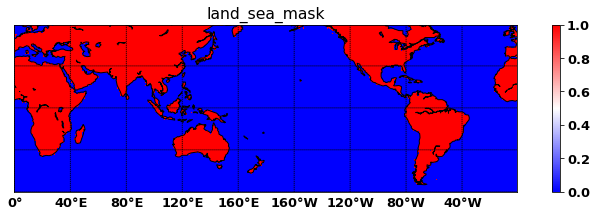

In [19]:
make_single_plot(ds_land_sea['GLDAS_mask'] ,
                 title = 'land_sea_mask',
                 vmin = 0, vmax = 1, 
                 cmap  =plt.get_cmap('bwr'))



In [303]:
cmips_mean_ds #['phase_cov']

<xarray.Dataset>
Dimensions:           (lat: 240, lon: 720)
Coordinates:
  * lat               (lat) float64 -60.0 -59.5 -59.0 -58.5 ... 58.5 59.0 59.5
  * lon               (lon) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Data variables:
    mu_season         (lat, lon) float64 0.09237 0.09253 ... 0.1231 0.1239
    sigma_season      (lat, lon) float64 1.483e-06 1.483e-06 ... 2.172e-06
    ampl_season       (lat, lon) float64 0.006387 0.006387 ... 0.008888 0.00931
    phase_season      (lat, lon) float64 3.049 3.146 3.07 ... 4.625 4.699 3.825
    ampl_cov_season   (lat, lon) float64 5.397e-15 5.297e-15 ... 1.107e-14
    phase_cov_season  (lat, lon) float64 0.07139 0.07402 ... 0.126 0.1066
    land_sea_mask     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

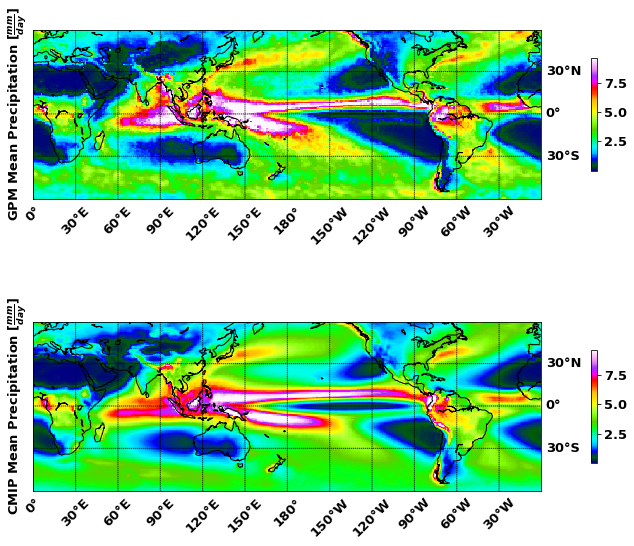

In [129]:


fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,9))


# make_single_plot(ds_gpm['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase [hours]',
#                  ax = ax_hist[0],
#                  fig = fig,
#                  ylabel = 'IMERG', 
#                  xticks_bool = False,
#                  cmap = plt.get_cmap('twilight_shifted'),
#                  vmin = 0, vmax = 24)





make_single_plot(ds_gpm['mu_season']*24, 
                 ax = ax_hist[0],
                 title = None,
                 fig = fig,
                 ylabel = r'GPM Mean Precipitation [$\frac{mm}{day}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
make_single_plot(cmips_mean_ds['mu_season'] *24, 
                 ax = ax_hist[1],
                 title = None,
                 fig = fig,
                 ylabel = r'CMIP Mean Precipitation [$\frac{mm}{day}$]',
                cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24)
# plt.savefig(save_figs_dir + 'tapio_update_8_26/' + 'mu_mean_spatial.png', dpi = 300)

# make_single_plot(cmips_mean_ds['mu_season'].where(cmips_mean_ds['mu_season'] > 0.04), 
#                  title = r'CMIP Mean Precipitation [$\frac{mm}{yr}$]',
#                   cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

In [112]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.00112189)

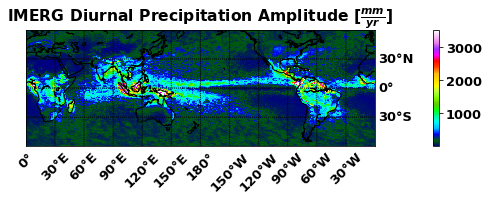

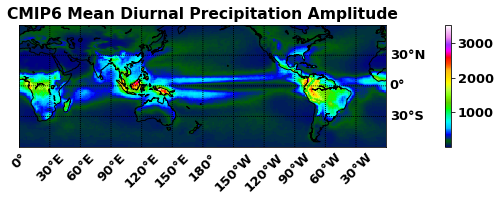

In [135]:
make_single_plot(ds_gpm['ampl_season']*MM_HR_TO_MM_YR, 
                 title = r'IMERG Diurnal Precipitation Amplitude [$\frac{mm}{yr}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*MM_HR_TO_MM_YR)
# plt.savefig(save_figs_dir + 'GPM/' + 'ampl_mean_spatial.png', dpi = 300)

make_single_plot(cmip6_mean_ds['ampl_season']*MM_HR_TO_MM_YR, 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*MM_HR_TO_MM_YR)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'ampl_mean_spatial.png', dpi = 300)

In [254]:
cmip6_mean_ds['ampl_season']

<xarray.DataArray 'ampl_season' (lat: 240, lon: 720)>
array([[1.77424907e-06, 1.77404718e-06, 1.84004412e-06, ...,
        1.82657440e-06, 1.80053514e-06, 1.77874803e-06],
       [1.78115941e-06, 1.78492269e-06, 1.85814124e-06, ...,
        1.83049625e-06, 1.80570691e-06, 1.78391980e-06],
       [1.78255370e-06, 1.78631697e-06, 1.85379687e-06, ...,
        1.83571705e-06, 1.81092772e-06, 1.78531409e-06],
       ...,
       [2.59111304e-06, 2.63660300e-06, 2.68212917e-06, ...,
        2.23492876e-06, 2.34699876e-06, 2.56657805e-06],
       [2.59310149e-06, 2.54652297e-06, 2.54798813e-06, ...,
        2.43032057e-06, 2.47792103e-06, 2.57486606e-06],
       [2.60444531e-06, 2.55786679e-06, 2.55200124e-06, ...,
        2.42137776e-06, 2.46897822e-06, 2.58620988e-06]])
Coordinates:
  * lat      (lat) float64 -60.0 -59.5 -59.0 -58.5 -58.0 ... 58.0 58.5 59.0 59.5
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5

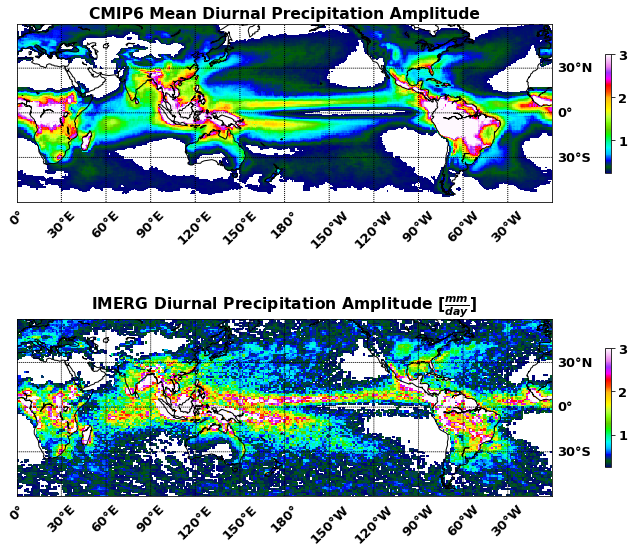

In [416]:
fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,9))

filter_ampl = 0.25
make_single_plot((cmips_mean_ds['ampl_season']*MM_HR_TO_MM_DAY).where((cmips_mean_ds['ampl_season']*MM_HR_TO_MM_DAY)> filter_ampl), 
                 fig = fig,
                 ax = ax_hist[0],
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 3)

make_single_plot((ds_gpm['ampl_season']*MM_HR_TO_MM_DAY).where((ds_gpm['ampl_season']*MM_HR_TO_MM_DAY)> filter_ampl),
                 fig = fig,
                 ax = ax_hist[1],
                 title = r'IMERG Diurnal Precipitation Amplitude [$\frac{mm}{day}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 3)


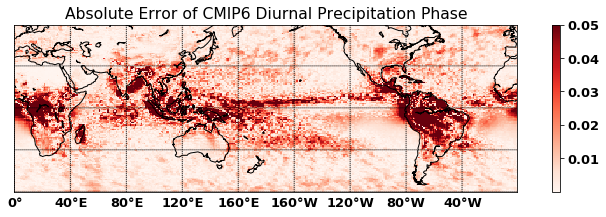

In [109]:
make_single_plot(cmips_err_ds['ampl_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'),vmax = 0.05)
# plt.savefig(save_figs_dir + 'compare_models/' + 'ampl_abs_error_spatial.png', dpi = 300)

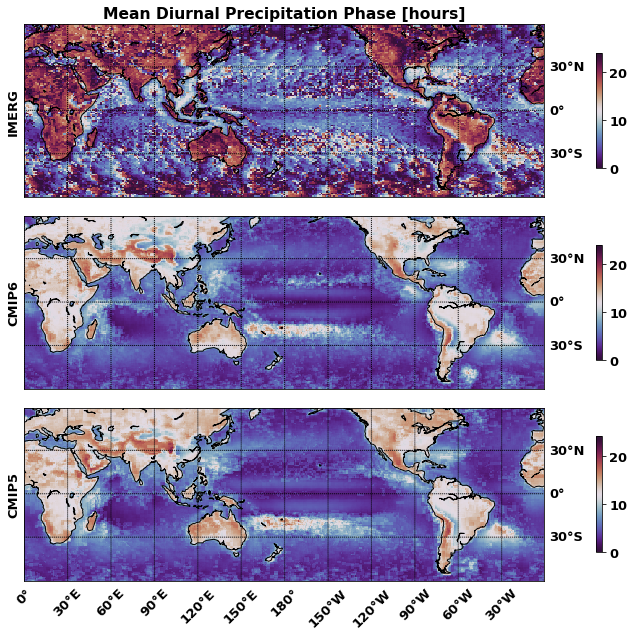

In [281]:
%run diurnal_utils.py


fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))


make_single_plot(ds_gpm['phase_season'], 
                 title = r'Mean Diurnal Precipitation Phase [hours]',
                 ax = ax_hist[0],
                 fig = fig,
                 ylabel = 'IMERG', 
                 xticks_bool = False,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

make_single_plot(cmip6_mean_ds['phase_season'], 
#                  title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 title = None,
                 ax = ax_hist[1],
                 fig = fig,
                 ylabel = 'CMIP6',
                 xticks_bool = False,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

make_single_plot(cmip5_mean_ds['phase_season'], 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
                 ax = ax_hist[2],
                 fig = fig,
                 ylabel = 'CMIP5',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)




fig.subplots_adjust(hspace=.01)
fig.savefig(save_figs_dir_paper + 'phase_mean_spatial_yearly.png', dpi = 300)



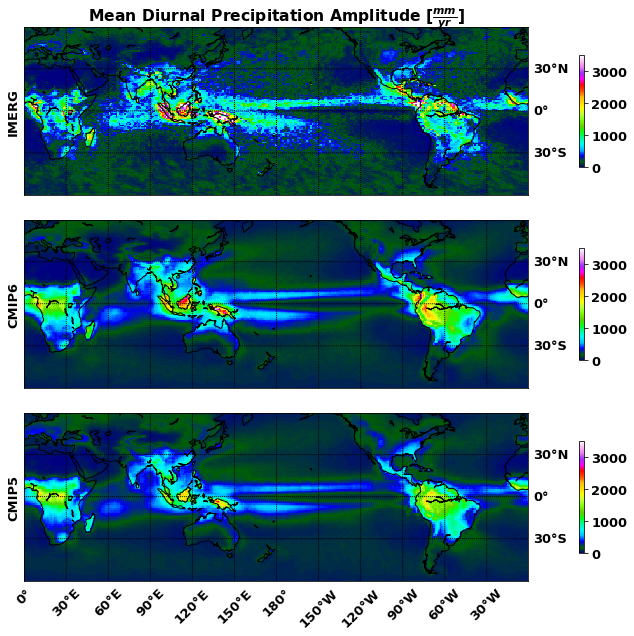

In [282]:
fig, ax_hist = plt.subplots(3, 1, sharex = True, figsize = (9,9))


make_single_plot(ds_gpm['ampl_season']*MM_HR_TO_MM_YR, 
                 title = r'Mean Diurnal Precipitation Amplitude [$\frac{mm}{yr}$]',
                 ax = ax_hist[0],
                 fig = fig,
                 ylabel = 'IMERG', 
                 xticks_bool = False,
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_YR)

make_single_plot(cmip6_mean_ds['ampl_season']*MM_HR_TO_MM_YR, 
#                  title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 title = None,
                 ax = ax_hist[1],
                 fig = fig,
                 ylabel = 'CMIP6',
                 xticks_bool = False,
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_YR)

make_single_plot(cmip5_mean_ds['ampl_season']*MM_HR_TO_MM_YR, 
#                  title = r'Mean Diurnal Precipitation Phase',
                 title = None, 
                 ax = ax_hist[2],
                 fig = fig,
                 ylabel = 'CMIP5',
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.4*MM_HR_TO_MM_YR)

fig.subplots_adjust(hspace=.01)

fig.savefig(save_figs_dir_paper + 'ampl_mean_spatial_yearly.png', dpi = 300)

In [315]:
# cmips_mean_ds
cmips_mean_ds['phase_cov_season'].to_dataset().apply(np.sqrt)

<xarray.Dataset>
Dimensions:           (lat: 240, lon: 720)
Coordinates:
  * lat               (lat) float64 -60.0 -59.5 -59.0 -58.5 ... 58.5 59.0 59.5
  * lon               (lon) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Data variables:
    phase_cov_season  (lat, lon) float64 0.2672 0.2721 0.2633 ... 0.355 0.3265

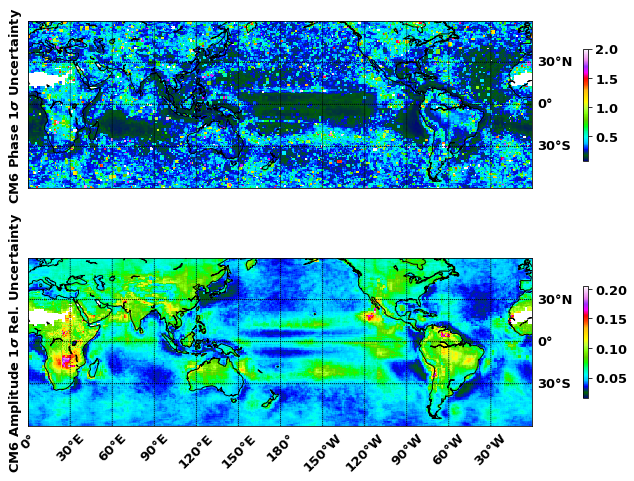

In [348]:
fig, ax_hist = plt.subplots(2, 1, sharex = True, figsize = (9,7))

make_single_plot(cmips_mean_ds['phase_cov_season'].to_dataset().apply(np.sqrt)['phase_cov_season'], 
                 ax = ax_hist[0],
                 title = None,
                 fig = fig,
                 xticks_bool = False,
                 ylabel = r'CM6 Phase $1 \sigma$ Uncertainty ',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 2)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)
ampl_rel_uncer = (FLUX_TO_MM_HR*cmips_mean_ds['ampl_cov_season'].to_dataset().apply(np.sqrt)['ampl_cov_season'])/cmips_mean_ds['ampl_season']
make_single_plot(ampl_rel_uncer,
                 ax = ax_hist[1],
                 title = None,
                 fig = fig,
                 ylabel = r'CM6 Amplitude $1 \sigma$ Rel. Uncertainty',
                cmap = plt.get_cmap('gist_ncar'))
fig.subplots_adjust(hspace=.001)
fig.tight_layout()
# plt.savefig(save_fig_dir_update + 'fit_error.png', dpi = 300)

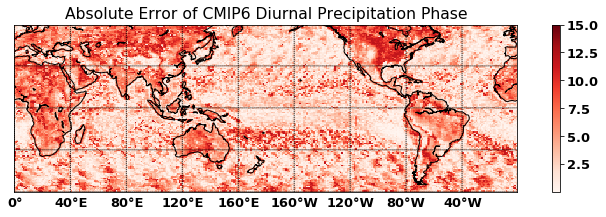

In [32]:
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'), vmin = -5, vmax = 5)
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('seismic_r'))
make_single_plot(cmips_err_ds['phase_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'), vmax = 15)
#                  vmin = 0, vmax = 3)
# plt.savefig(save_figs_dir + 'compare_models/' + 'phase_abs_error_spatial.png', dpi = 300)

# Taylor Plots

In [95]:
# gpm_std = df_gpm[field].std()
gpm_std =  circstd(df_gpm['phase_season'], low = 0.0, high = 24.0)
gpm_land_std = circstd(df_gpm_land['phase_season'], low = 0.0, high = 24.0)
gpm_water_std = circstd(df_gpm_water['phase_season'],low = 0.0, high = 24.0)

# # calculate obs ampl
# obs_water_std = hour_circstd(obs_water_df['phase_season'])
# obs_land_std = hour_circstd(obs_land_df['phase_season'])


In [249]:
# input_data_dir_rlut
# mean_fields_to_rel_path_map

{'rlut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rlut_regridded/grid1/',
 'rsut': '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rsut_regridded/grid1/',
 'pr': '/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr_regridded/grid1/',
 'clt': '/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/clt_regridded/grid1/'}

In [ ]:
# os.listdir(input_data_dir_rlut)
%run model_by_model_analysis_helper.py

In [79]:


%run model_by_model_analysis_helper.py

# tropics
# min_lat, max_lat = -30, 30
# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                        filter_by_lat = True,
#                        **{'min_lat': min_lat,
#                        'max_lat': max_lat})


# # tropics water
# min_lat, max_lat = -30, 30
# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt', 'cltl', 'clth'],
#                       mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                       file_name = 'grid1_1985-01_2006-01_mean.nc',
#                       filter_lat = True,
#                       landsea_mask_df = df_land_sea,
#                       landsea_bool = 0,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': False})
# subtropics
# min_lat, max_lat = 30, 60
min_lat, max_lat = -30, 30

# field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt'],
#                        mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
#                        filter_lat = True,
#                        **{'min_lat': min_lat,
#                           'max_lat': max_lat,
#                           'absolute_value': True})


rr = _get_mean_field(field_name = 'cltl',
                      data_dir = mean_fields_to_rel_path_map['cltl'],
                      file_name = 'grid1_1985-01_2006-01_mean.nc',
                      filter_lat = True,
                      landsea_mask_df = df_land_sea,
#                       var_mask_df = precip_mask_df,
                      landsea_bool = 0,
                       **{'min_lat': min_lat,
                          'max_lat': max_lat,
                          'absolute_value': False})




# stats_kwargs = {'ecs_dict': cmip6_ecs, 'tcr_dict': cmip6_tcr, 
#      'rlut_dict': rlut_dict, 'rsut_dict': rsut_dict, 
#      'pr_dict': pr_dict, 'clt_dict': clt_dict}

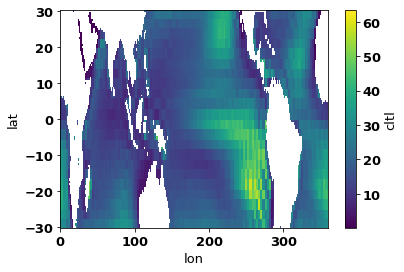

In [80]:
dds = xr.Dataset.from_dataframe(rr)
dds['cltl'].plot.imshow()

In [257]:
# dds['cltl'].plot.imshow(vmax = 20)

In [86]:
# ds_clt = xr.open_dataset(mean_fields_to_rel_path_map['clt'] + 'grid1_1985-01_2006-01_mean.nc')

In [278]:
# field_means_df

rlut        rsut        pr        clt       clth  \
IPSL-CM6A-LR      245.581949  100.630701  0.000066  58.317680        NaN   
CNRM-ESM2-1       243.265625  106.294609  0.000068  75.177654   6.928708   
CNRM-CM6-1        243.735855  105.902515  0.000066  74.380500   6.735105   
EC-Earth3-Veg     250.534637   97.503958  0.000064  66.291020        NaN   
AWI-CM-1-1-MR     255.514107   87.502388  0.000069  63.675664        NaN   
FGOALS-g3         235.540624  109.519921  0.000073  58.088681  11.293168   
CanESM5           246.603469   97.382636  0.000068  72.256752   5.529827   
MIROC6            233.128613  126.340501  0.000076  67.407366   2.320024   
MPI-ESM1-2-LR     255.429304   87.989330  0.000066  66.161626        NaN   
SAM0-UNICON       247.442935  101.546519  0.000071  66.049570  11.707444   
BCC-CSM2-MR       251.911637   96.340788  0.000065  73.980845   6.598142   
AWI-ESM-1-1-LR    256.218121   90.236964  0.000059  65.975829   5.610644   
ACCESS-ESM1-5     254.135652   95.880566  0.000072  67.945745        NaN   
EC-Earth3-Veg-LR  247.400860  101.283767  0.000062  67.389318        NaN   
NESM3             241.668484  106.096132  0.000050  68.610057   7.904253   
ACCESS-CM2        253.388438   91.615775  0.000069  71.891802        NaN   
MPI-ESM-1-2-HAM   259.204861   88.535009  0.000059  64.607187        NaN   
MPI-ESM1-2-HR     255.983750   86.090039  0.000068  62.697756   3.179554   
GISS-E2-1-G       246.441940   98.831634  0.000063  68.063710   2.146840   
MRI-ESM2-0        246.248893   97.767588  0.000070  65.629419   5.402408   
MIROC-ES2L        241.963092  123.786331  0.000073  64.345982   3.175227   
UKESM1-0-LL       249.791722   93.841020  0.000072  71.981393        NaN   
KACE-1-0-G        251.673031   92.067848  0.000069  72.248559        NaN   
CMCC-CM2-SR5      249.923846  100.412855  0.000068  65.692942  10.920112   
EC-Earth3         250.290105   97.743241  0.000064  66.306466        NaN   
FGOALS-f3-L              NaN         NaN       NaN        NaN   8.428991   
CESM2                    NaN         NaN       NaN        NaN        NaN   

                       cltl  
IPSL-CM6A-LR            NaN  
CNRM-ESM2-1        6.194155  
CNRM-CM6-1         6.152584  
EC-Earth3-Veg           NaN  
AWI-CM-1-1-MR           NaN  
FGOALS-g3         10.352618  
CanESM5            6.718170  
MIROC6             5.553712  
MPI-ESM1-2-LR      3.062676  
SAM0-UNICON        5.420655  
BCC-CSM2-MR        5.134573  
AWI-ESM-1-1-LR     3.629554  
ACCESS-ESM1-5           NaN  
EC-Earth3-Veg-LR        NaN  
NESM3              2.431944  
ACCESS-CM2              NaN  
MPI-ESM-1-2-HAM         NaN  
MPI-ESM1-2-HR      2.270558  
GISS-E2-1-G        7.670195  
MRI-ESM2-0         5.086632  
MIROC-ES2L         5.756574  
UKESM1-0-LL             NaN  
KACE-1-0-G              NaN  
CMCC-CM2-SR5      12.445528  
EC-Earth3               NaN  
FGOALS-f3-L        4.894302  
CESM2                   NaN

In [283]:
%run model_by_model_analysis_helper.py




In [113]:
cmip_sens = cmip6_sensitivities.reset_index().rename({'index':'model_name'}, axis = 1)
cmip_means = field_means_df.reset_index().rename({'index':'model_name'}, axis = 1)
# merged_df = pd.merge(df_for_stats_water.reset_index(), cmip_sens,
#                     how = 'left',
#                     on = 'model_name')
merged_df = pd.merge(df_for_stats_water.reset_index(), cmip_means,
                    how = 'left',
                    on = 'model_name')

In [253]:
# corr_map_df
# field_means_df


In [114]:
%%time
corr_map_df = pd.DataFrame()
for lat_ii in merged_df['lat'].unique():
    print(lat_ii)
    for lon_ii in merged_df['lon'].unique():
        grid_cell_df = merged_df[(merged_df['lat'] == lat_ii) & (merged_df['lon'] == lon_ii)]
        out_df_row = grid_cell_df.corr()['clt']
        out_df_row['lat'] = lat_ii
        out_df_row['lon'] = lon_ii
        
        corr_map_df = corr_map_df.append(out_df_row)
# res = merged_df[['lat','lon','phase_season', 'ecs', 'tcr']].groupby(['lat','lon']).corr()


-60.0
-59.5
-59.0
-58.5
-58.0
-57.5
-57.0
-56.5
-56.0
-55.5
-55.0
-54.5
-54.0
-53.5
-53.0
-52.5
-52.0
-51.5
-51.0
-50.5
-50.0
-49.5
-49.0
-48.5
-48.0
-47.5
-47.0
-46.5
-46.0
-45.5
-45.0
-44.5
-44.0
-43.5
-43.0
-42.5
-42.0
-41.5
-41.0
-40.5
-40.0
-39.5
-39.0
-38.5
-38.0
-37.5
-37.0
-36.5
-36.0
-35.5
-35.0
-34.5
-34.0
-33.5
-33.0
-32.5
-32.0
-31.5
-31.0
-30.5
-30.0
-29.5
-29.0
-28.5
-28.0
-27.5
-27.0
-26.5
-26.0
-25.5
-25.0
-24.5
-24.0
-23.5
-23.0
-22.5
-22.0
-21.5
-21.0
-20.5
-20.0
-19.5
-19.0
-18.5
-18.0
-17.5
-17.0
-16.5
-16.0
-15.5
-15.0
-14.5
-14.0
-13.5
-13.0
-12.5
-12.0
-11.5
-11.0
-10.5
-10.0
-9.5
-9.0
-8.5
-8.0
-7.5
-7.0
-6.5
-6.0
-5.5
-5.0
-4.5
-4.0
-3.5
-3.0
-2.5
-2.0
-1.5
-1.0
-0.5
0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5
20.0
20.5
21.0
21.5
22.0
22.5
23.0
23.5
24.0
24.5
25.0
25.5
26.0
26.5
27.0
27.5
28.0
28.5
29.0
29.5
30.0
30.5
31.0
31.5

In [115]:
corr_map_df = corr_map_df.set_index(['lat','lon'])

In [116]:
corr_map_ds = xr.Dataset.from_dataframe(corr_map_df)

In [117]:
corr_map_ds

<xarray.Dataset>
Dimensions:           (lat: 240, lon: 720)
Coordinates:
  * lat               (lat) float64 -60.0 -59.5 -59.0 -58.5 ... 58.5 59.0 59.5
  * lon               (lon) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Data variables:
    ampl_cov_season   (lat, lon) float64 -0.4544 -0.3203 ... 0.05948 -0.05486
    ampl_season       (lat, lon) float64 0.01194 -0.08263 ... 0.1731 0.2053
    clt               (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    clth              (lat, lon) float64 0.1406 0.1406 0.1406 ... 0.1406 0.1406
    cltl              (lat, lon) float64 -0.1749 -0.1749 ... -0.1749 -0.1749
    land_sea_mask     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    mu_season         (lat, lon) float64 0.2241 0.206 0.2074 ... 0.3273 0.3049
    phase_cov_season  (lat, lon) float64 -0.315 0.06868 ... -0.2115 0.1304
    phase_season      (lat, lon) float64 0.2919 0.2427 0.2484 ... 0.29 0.197
    pr                (lat, lon) float64 0.3308 0.3308 0.3308 ... 0.3308 0.3308
    rlut              (lat, lon) float64 0.2775 0.2775 0.2775 ... 0.2775 0.2775
    rsut              (lat, lon) float64 -0.1866 -0.1866 ... -0.1866 -0.1866
    sigma_season      (lat, lon) float64 -0.08345 -0.1333 ... 0.1747 0.2177

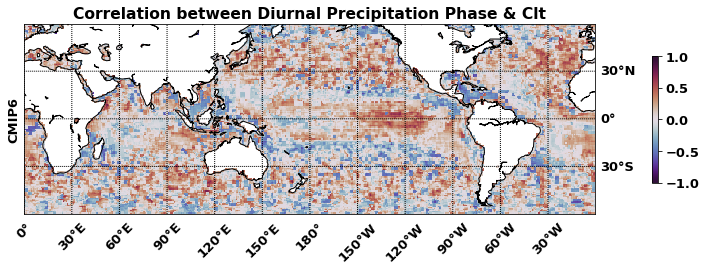

In [120]:
# corr_map_ds['phase_season'].plot.imshow()
fig = plt.figure(figsize = (10,8))
make_single_plot(corr_map_ds['phase_season'], 
                 title = r'Correlation between Diurnal Precipitation Phase & Clt',
                 ax = plt.gca(),
                 fig = fig,
                 ylabel = 'CMIP6', 
                 xticks_bool = True,
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = -1, vmax = 1)
# plt.savefig(save_figs_dir + 'tapio_update_8_26/' + 'phase_corr_clt_map.png', dpi = 300)

In [130]:
ds_gpm

<xarray.Dataset>
Dimensions:           (lat: 240, lon: 720)
Coordinates:
  * lon               (lon) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * lat               (lat) float64 -60.0 -59.5 -59.0 -58.5 ... 58.5 59.0 59.5
Data variables:
    mu_season         (lat, lon) float64 0.1088 0.1088 0.1088 ... 0.1472 0.1472
    sigma_season      (lat, lon) float64 0.01859 0.01859 ... 0.02115 0.02115
    ampl_season       (lat, lon) float64 0.01114 0.01114 ... 0.008098 0.008098
    phase_season      (lat, lon) float64 23.22 23.22 23.22 ... 18.38 1.582 1.582
    ampl_cov_season   (lat, lon) float64 4.738e-06 4.738e-06 ... 7.116e-06
    phase_cov_season  (lat, lon) float64 0.6886 0.6886 0.6886 ... 3.623 3.623
    land_sea_mask     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [132]:
# corr_map_ds['phase_season'].where(ds_gpm['mu_season'] < 50).plot.imshow()


In [90]:
# compute stats for all points
# df_for_stats[df_for_stats['ampl_season']> 0.001
%run model_by_model_analysis_helper.py
# model_error_stats_df= compute_stats(df_for_stats,
#                  df_for_stats_true,
#                  field = 'phase_season',
#                  agg_method = 'mode',
#                  error_stats = True,
#                  additional_stats = True,)                

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  field = 'phase_season',
#                  agg_method = 'mode',
#                  additional_stats = True,)


# ### compute stats for land/water
# model_error_stats_df_water = compute_stats(df_for_stats_water,
#                  df_for_stats_true_water,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True,)


# model_error_stats_df_water = compute_stats(filter_by_lat(df_for_stats_water, min_lat, max_lat),
#                  filter_by_lat(df_for_stats_true_water, min_lat, max_lat),
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

####### compute stats for given latitude range
# min_lat, max_lat = -60, 60
# # # # min_lat, max_lat = 30, 60
# # # # min_lat, max_lat = 0, 60

# # # # min_lat, max_lat = 30, 60
# absolute_values = False

# # # print(min_lat, max_lat)
# # df_for_stats_filt = filter_by_lat(df_for_stats, min_lat, max_lat, absolute_value=False)
# # df_for_stats_true_filt = filter_by_lat(df_for_stats_true, min_lat, max_lat, absolute_value=False)


# df_for_stats_filt_land = filter_by_lat(df_for_stats_land, min_lat, max_lat, absolute_value=absolute_values)
# df_for_stats_true_filt_land = filter_by_lat(df_for_stats_true_land, min_lat, max_lat, absolute_value=absolute_values)


# df_for_stats_filt_water = filter_by_lat(df_for_stats_water, min_lat, max_lat, absolute_value=absolute_values)
# df_for_stats_true_filt_water = filter_by_lat(df_for_stats_true_water, min_lat, max_lat, absolute_value=absolute_values)



# # model_error_stats_df = compute_stats(df_for_stats_filt,
# #                  df_for_stats_true_filt,
# #                  agg_method = 'mean',
# #                  field = 'phase_season',
# #                  additional_stats = True, 
# #                  **stats_kwargs)
                

    
    

# model_error_stats_df_water = compute_stats(df_for_stats_filt_water,
#                  df_for_stats_true_filt_water,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',)

# model_error_stats_df_land = compute_stats(df_for_stats_filt_land,
#                  df_for_stats_true_filt_land,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',)

In [230]:
# # tropics water
min_lat, max_lat = -60, 60
field_means_df = _get_mean_fields(field_names = ['rlut','rsut', 'pr', 'clt', 'clth','cltl'],
                      mean_fields_to_rel_path_map = mean_fields_to_rel_path_map,
                      file_name = 'grid1_1985-01_2006-01_mean.nc',
                      var_mask_df = precip_mask_df,
                      filter_lat = True,
                      landsea_mask_df = df_land_sea,
                      landsea_bool = 0,
                       **{'min_lat': min_lat,
                          'max_lat': max_lat,
                          'absolute_value': False})

In [221]:
# field_means_df

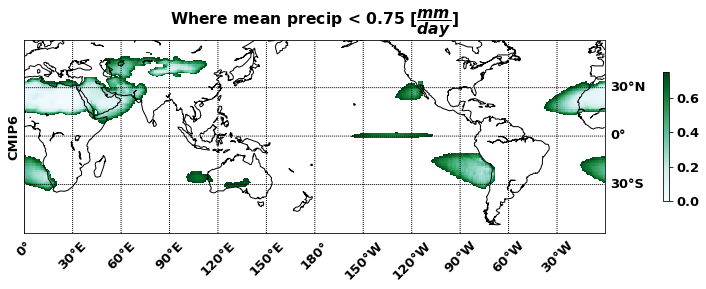

In [228]:
# field_means_df
fig = plt.figure(figsize = (10,8))
precip_where = (cmips_mean_ds['mu_season']*24).where(cmips_mean_ds['mu_season']*24 < 0.75)
make_single_plot(precip_where, 
#                  title = r'Correlation between Diurnal Precipitation Phase & Clt',
                 title = 'Where mean precip < 0.75 [$\dfrac{mm}{day}$]',
                 ax = plt.gca(),
                 fig = fig,
                 ylabel = 'CMIP6', 
                 xticks_bool = True,
                 cmap = plt.get_cmap('BuGn'),
                 vmin = 0)
plt.savefig(save_fig_dir_update + 'mean_precip_lt_0pt75_map.png', dpi = 300)

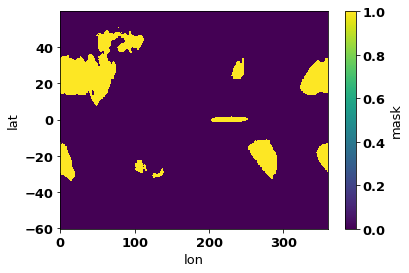

In [229]:
precip_mask = (precip_where > 0)
precip_mask.name = 'mask'
precip_mask_df = precip_mask.to_dataframe()
precip_mask.plot.imshow()

In [455]:
# precip_mask == 0

In [268]:

### select season
# season_ii = 'DJF'
# df_for_analysis = model_error_stats_df_water
# df_for_analysis = df_for_analysis.reset_index('season')
# df_for_analysis = df_for_analysis[df_for_analysis['season'] == season_ii]


### yearly mean
df_for_analysis = model_error_stats_df_water

merge_sensitivities = pd.merge(df_for_analysis, cmip5_sensitivities, 
         how = 'left',
         left_index = True, 
         right_index = True)
all_stats_df = pd.merge(merge_sensitivities, field_means_df,
         how = 'left',
         left_index = True, 
         right_index = True)

NameError: name 'model_error_stats_df_water' is not defined

In [211]:
# df_cmip6

In [263]:
# df_cmip6_seasonal.index


In [231]:
%%time
%run model_by_model_analysis_helper.py


cmip6_stats_water, cmip6_stats_land = full_analysis(df_cmip6,
                    df_gpm,
                    cmip6_sensitivities,
                    field_means_df, 
                    var_mask_df = precip_mask_df,
                    min_lat = -60, 
                    max_lat = 60)

# cmip6_stats_water_winter, _ = full_analysis(df_cmip6_seasonal,
#                                             df_gpm_seasonal,
#                                             cmip6_sensitivities,
#                                             field_means_df,
#                                             min_lat = -30,
#                                             max_lat = 0)
# cmip6_stats_water_winter = cmip6_stats_water_winter[cmip6_stats_water_winter['season'] == 'JJA']


# cmip5_stats_water, cmip5_stats_land = full_analysis(df_cmip5,
#                     df_gpm,
#                     cmip5_sensitivities)

# cmip5_stats_water_summer, _ = full_analysis(df_cmip5_seasonal,
#                                             df_gpm_seasonal,
#                                             cmip5_sensitivities,
#                                             min_lat = 0,
#                                             max_lat = 60)
# cmip5_stats_water_summer = cmip5_stats_water_summer[cmip5_stats_water_summer['season'] == 'JJA']

/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


CPU times: user 23.6 s, sys: 3.56 s, total: 27.2 s
Wall time: 17.4 s


In [96]:
# field_means_df
# ddds = xr.Dataset.from_dataframe(cmip6_stats_water)
# dds = xr.Dataset.from_dataframe(cmip6_stats_water[cmip6_stats_water['model_name'] == 'MIROC-ES2L'])
# dds['phase_season'].plot.imshow()

In [208]:
# df_cmip6['ampl_season']

In [490]:
# cmip6_stats_water_summer
mode(cmip6_stats_land['phase_mean'].values)


ModeResult(mode=array([12.8]), count=array([2]))

In [491]:
mode(cmip5_stats_land['phase_mean'].values)

ModeResult(mode=array([11.6]), count=array([2]))

In [492]:
mode(df_gpm_land['phase_season'].round(1).values)

ModeResult(mode=array([19.2]), count=array([828]))

In [123]:
# save_fig_corr_heatmap_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/corr_heatmaps/CMIP6/'
save_fig_corr_heatmap_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/tapio_update_9_10/' 

## Make Correlation Heatmap

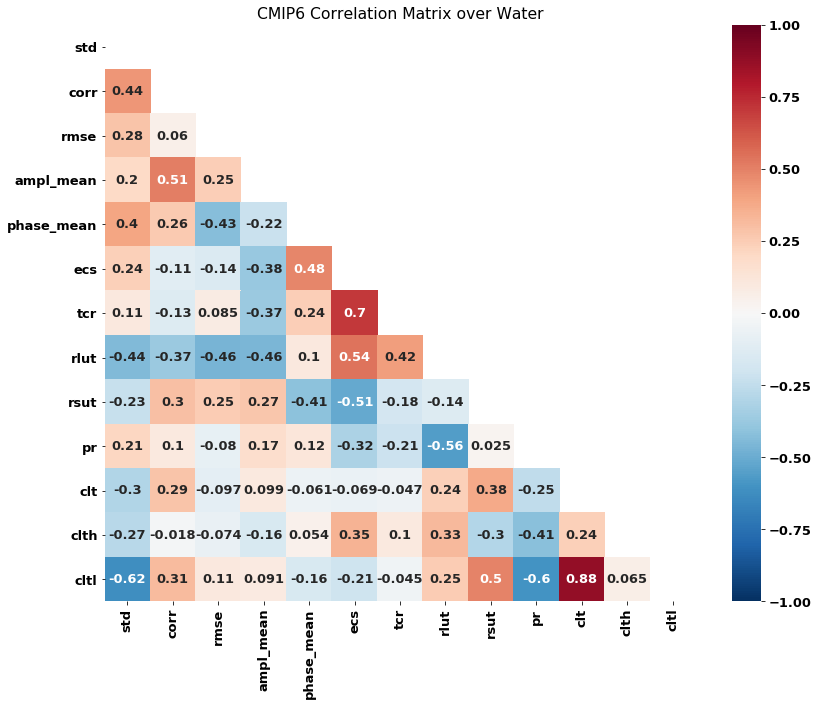

In [233]:
%run model_by_model_analysis_helper.py
corr_mat_ds = cmip6_stats_water

plot_corr_matrix(corr_mat_ds, 
                 title = 'CMIP6 Correlation Matrix over Water')


plt.savefig(save_fig_dir_update + 'cmip6_corr_mat_water_precip_ls_0pt75.png', dpi = 300)
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_mat_water_max_cloud_cover.png', dpi = 300)
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_mat_water_nh_all_djf.png', dpi = 300)

In [224]:
# model_error_stats_df #.reset_index('season')

corr_mat_ds = all_stats_df
# .drop(['IPSL-CM6A-LR']) #.drop(['BCC-CSM2-MR']) #.drop(['GFDL-ESM2M', 'MIROC5'])

# mes_df_season = model_error_stats_df.reset_index('season')
# mes_df_season = mes_df_season[mes_df_season['season'] == 'JJA']

# corr_mat_ds = mes_df_season

# plt.figure(figsize = (12,10))
# plt.title('Correlation Matrix for All Latitudes [Method: mode]')
# upper_tr_mask = np.triu(corr_mat_ds.corr())
# sns.heatmap(corr_mat_ds.corr(), annot = True, 
#             vmin = -1, vmax = 1, center = 0, fmt='.2g',
#             mask = upper_tr_mask)

# plt.tight_layout()
plot_corr_matrix(corr_mat_ds)
# plt.savefig(save_figs_dir + 'corr_heatmaps/CMIP6/' + 'land_and_water_poleward_of_35.png', dpi = 300)

NameError: name 'all_stats_df' is not defined

In [94]:
# model_error_stats_df
# model_error_stats_df.sort_values('rmse')

In [65]:
def metric_scatter(df, x_field = 'phase_mean', 
                   y_field = 'ecs',
                   xlabel = 'Phase Mean [Hours]',
                   ylabel = 'ECS',
                   figsize = (8,5),
                   annotate_bool = True):
    plt.figure(figsize = figsize)
    # for mod_ii in model_error_stats_df.iterrows():
    model_list = list(df.index)
    for ii in range(len(df)):
        mod_ii = df.iloc[ii,:]
        xx,yy = mod_ii[x_field], mod_ii[y_field]
        if (not np.isnan(xx)) & (not np.isnan(yy)):
            plt.plot(xx, yy, 'o', label = str(ii) + ': ' + model_list[ii])
            plt.annotate(str(ii), (xx, yy), size = 9, weight = 'bold')
    plt.grid()
    plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5),prop={'size': 8})
    if xlabel:
        plt.xlabel(xlabel, weight = 'bold')
        
    if ylabel:
        plt.ylabel(ylabel, weight = 'bold')
    
    corr = df.corr()[x_field][y_field]
    print(corr)
    if annotate_bool:
        plt.annotate('Corr:' + '{:.3f}'.format(corr), 
                     xy=(0.75, 0.01), xycoords='axes fraction')


    plt.tight_layout()

In [543]:

# metric_scatter(model_error_stats_df_land)
# plt.title('CMIP6 ECS vs. Diurnal Phase Land', weight = 'bold')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_land.png', dpi = 300)


metric_scatter(all_stats_df)
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_25n_25_s.png', dpi = 300)

# metric_scatter(model_error_stats_df_land, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Land', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_land.png', dpi = 300)


# metric_scatter(model_error_stats_df_water, y_field = 'tcr')
# plt.title('CMIP6 TCR vs. Diurnal Phase Water', weight = 'bold')
# plt.ylabel('TCR')
# # plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_water.png',  dpi = 300)



NameError: name 'all_stats_df' is not defined

-0.0413181292459667


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Phase Water')

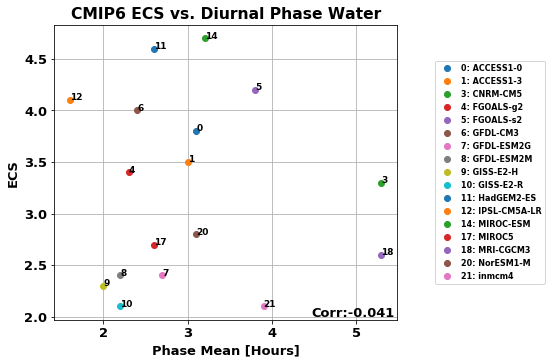

NameError: name 'save_figs_dir_update' is not defined

0.4848476642098888


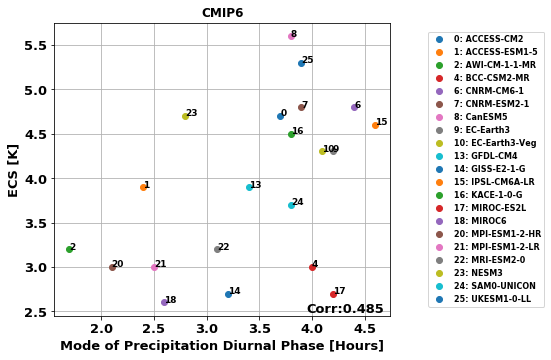

In [234]:
# plt.figure(figsize = (7,10))

metric_scatter(cmip6_stats_water,  
               x_field = 'phase_mean',  
               y_field = 'ecs',
               xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
               ylabel = 'ECS [K]',
               figsize = (8,5), 
               annotate_bool=True)
# plt.xticks(rotation=45)
plt.title('CMIP6', weight = 'bold', fontsize = 12)
# save_fig_dir_update
plt.savefig(save_fig_dir_update + 'ecs_vs_phase_water_precip_lt_0pt75.png', dpi = 300)
# plt.savefig(save_figs_dir_paper + 'ecs_vs_phase_water_nh_summer.png', dpi = 300)
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_phase_ecs_water.png', dpi = 250)





# metric_scatter(cmip6_stats_water, 
#                x_field = 'phase_mean',  
#                y_field = 'ecs',
#                xlabel = 'Mode of Precipitation Diurnal Phase [Hours]',
#                ylabel = 'ECS [K]',
#                figsize = (8,5), 
#                annotate_bool=True)
# # plt.xticks(rotation=45)
# plt.title('CMIP6', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_new.png', dpi = 300)




-0.06881746185253784


Text(0.5, 1, 'CMIP6')

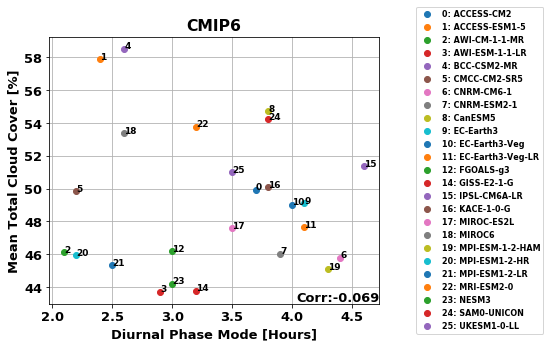

In [201]:
# sanity check modes
# mode_apply(df_cmip5[df_cmip5['model_name'] == 'GFDL-ESM2G'].round(1)['phase_season'])

metric_scatter(cmip6_stats_water,  
               y_field = 'clt', 
               x_field = 'phase_mean',
               xlabel = 'Diurnal Phase Mode [Hours]',
               figsize = (8,5), 
               ylabel = 'Mean Total Cloud Cover [%]',)
plt.title('CMIP6', weight = 'bold')
# plt.savefig(save_fig_dir_update + 'clt_vs_phase_water_precip_gt_1pt5.png', dpi = 300)



In [204]:
# cmip6_stats_water


-0.37620665255733954


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Amplitude')

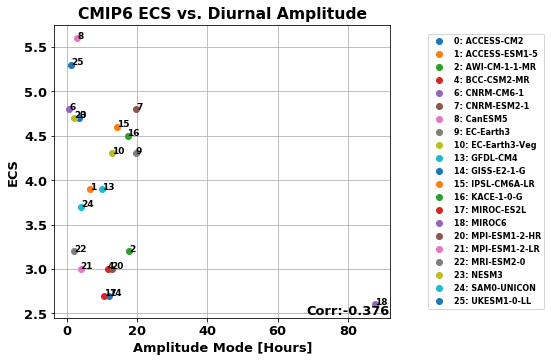

In [235]:
metric_scatter(cmip6_stats_water,  
               y_field = 'ecs', x_field = 'ampl_mean',
               xlabel = 'Amplitude Mode [Hours]')
plt.title('CMIP6 ECS vs. Diurnal Amplitude', weight = 'bold')

0.5175684485542283


Text(0.5, 1, 'CMIP6 Mean Outgoing Shortwave Radiation vs. Diurnal Amplitude')

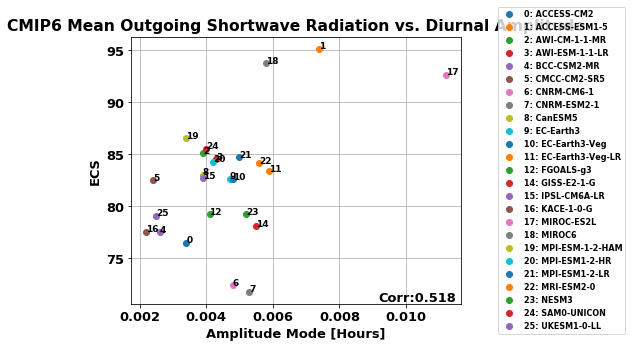

In [225]:
metric_scatter(cmip6_stats_water,  
               y_field = 'rsut', x_field = 'ampl_mean',
               xlabel = 'Amplitude Mode [Hours]')
plt.title('CMIP6 Mean Outgoing Shortwave Radiation vs. Diurnal Amplitude', weight = 'bold')
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)




In [248]:
# metric_scatter(model_error_stats_df,  y_field = 'rlut', x_field = 'rsut')
# plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)





0.24853418886369344


Text(0.5, 1, 'CMIP6')

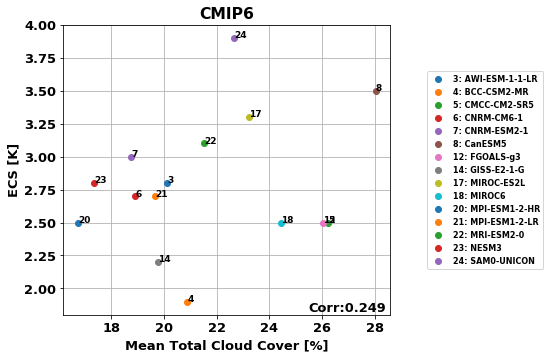

In [113]:
metric_scatter(cmip6_stats_water,  
               y_field = 'phase_mean', 
               x_field = 'cltl',
               ylabel = 'ECS [K]',
               xlabel = 'Mean Total Cloud Cover [%]',)
plt.title('CMIP6', weight = 'bold')
# plt.savefig(save_fig_corr_heatmap_dir + 'cmip6_corr_clt_ecs_water.png', dpi = 250)




# plt.savefig(save_figs_dir + 'diurnal_vs_climate/' + 'ecs_vs_tcr_cmip6.png',  dpi = 300)



In [38]:
# Create Taylor Diagram
# import taylorDiagram
# %%capture
%run taylorDiagram.py

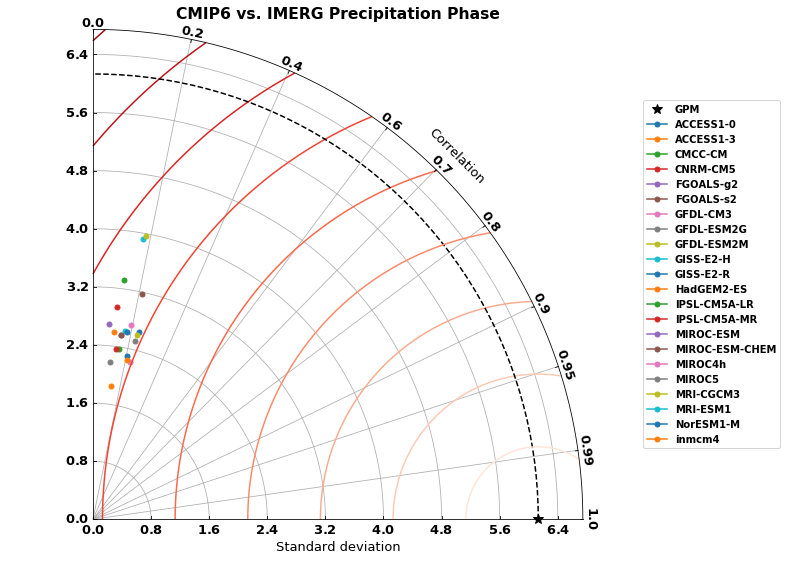

In [101]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_water.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_water.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_water.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP6 vs. IMERG Precipitation Phase', weight = 'bold')
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_water.png', dpi = 300)

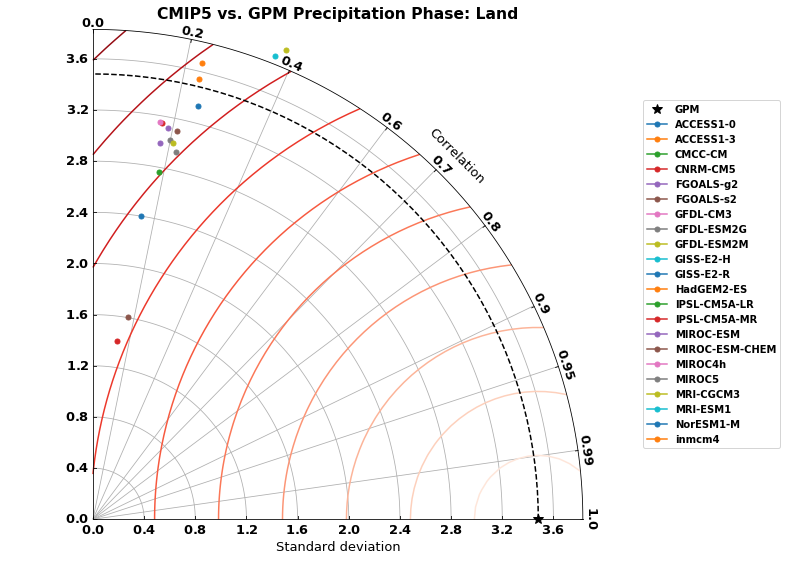

In [96]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_land_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_land.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_land.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_land.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP5 vs. GPM Precipitation Phase: Land', weight = 'bold')
plt.tight_layout()

# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_land.png', dpi = 300)

In [93]:
# mode_apply(df_for_stats_true_water['phase_season'])
# df_for_stats_true.plot(x = 'ampl_season', y = 'phase_season' , kind = 'scatter')
# sns.jointplot('ampl_season', 'phase_season', data = df_for_stats_true, 
#               kind = 'hex', xlim = [0, 0.2])
# _ = plt.hist2d(df_for_stats_true['ampl_season'], df_for_stats_true['phase_season'], bins = 300,
#               density = True, cmap = plt.get_cmap('gist_ncar'))
# plt.xlim([0, 0.2])
# plt.colorbar()

In [456]:
import importlib
# import PhaseDiagram
importlib.reload(phaseDiagram)

# %run phaseDiagram.py
%run model_by_model_analysis_helper.py




# make_phase_plot(model_error_stats_df_water,
#                 model_error_stats_df_land,
#                 df_for_stats_true_land, 
#                 df_for_stats_true_water,
#                )

ModuleNotFoundError: No module named 'PhaseDiagram'

Text(0.5, 1.05, 'Diurnal Phase [hr] & Amplitude [$\\frac{mm}{yr}$] for CMIP5 and IMERG')

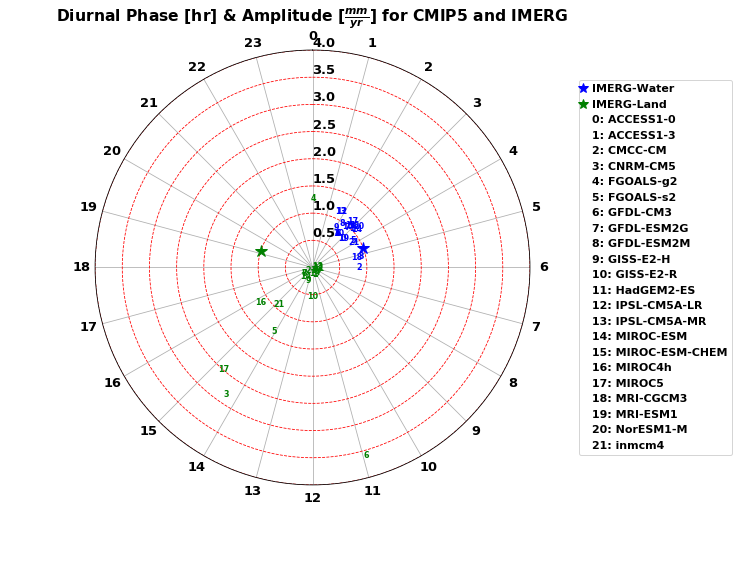

In [164]:
%run phaseDiagram.py

fig = plt.figure(figsize = (13,8))
# plt.title('Test')

markersize = 2
textsize = 8
normalize_ampl = True

ampl_unit_conversion_factor = MM_HR_TO_MM_YR
taylor_diag = PhaseDiagram(
                          fig = fig, 
                          label = 'IMERG', 
                          y_lim=(0, 4),
                          radial_label_pos = 0
                          )
taylor_diag.add_grid()

ampl_observed_water = mode_apply(df_for_stats_true_water['ampl_season'].round(4)* ampl_unit_conversion_factor)
ampl_observed_land = mode_apply(df_for_stats_true_land['ampl_season'].round(4)* ampl_unit_conversion_factor)

if normalize_ampl:
    ampl_to_plot_water = 1.0
    ampl_to_plot_land = 1.0
else:
    ampl_to_plot_water = ampl_observed_water
    ampl_to_plot_land = ampl_observed_land
    
taylor_diag.add_sample(phase = mode_apply(df_for_stats_true_water['phase_season'].round(1)), 
                           ampl = ampl_to_plot_water, 
                           marker = '*', 
                           c = 'b',
                           label = 'IMERG-Water', 
                           markersize = 13)

taylor_diag.add_sample(phase = mode_apply(df_for_stats_true_land['phase_season'].round(1)), 
                           ampl = ampl_to_plot_land, 
                           marker = '*', 
                           c = 'g',
                           label = 'IMERG-Land', 
                           markersize = 13)


## Plot model phase/ampl over water
model_list = list(model_error_stats_df_water.index)
for model_name_i in range(len(model_list)):

    phase_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['ampl_mean'] * ampl_unit_conversion_factor

    if normalize_ampl:
        ampl_i = ampl_i/ampl_observed_water
    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None,
                           linestyle = None,
                           c = 'b',
                           label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           markersize = markersize)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         label = str(model_name_i) + ': ' + model_list[model_name_i], 
                         c = 'b',
                         size = textsize,
                         weight = 'bold')
    
## Plot model phase/ampl over land
for model_name_i in range(len(model_list)):
    phase_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['ampl_mean'] * ampl_unit_conversion_factor
    
    if normalize_ampl:
        ampl_i = ampl_i/ampl_observed_land
        
    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None, 
                           c = 'g',
                           linestyle = None,
#                            label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           label = None,
                           markersize = markersize)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         c = 'g',
                         size = textsize,
                         weight = 'bold')



leg = plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 11}, handlelength = 0, markerscale = 0.8)

    
plt.title(r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{yr}$] for CMIP5 and IMERG', weight = 'bold')
# plt.title(r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{hr}$] : CMIP6 vs. GPM Poleward of 35 N/S (Method: mode)', weight = 'bold')
# plt.tight_layout()

# plt.savefig(save_figs_dir + 'phase_ampl_plots/CMIP6/' + 'all_cmip6_land_water_pw_35NS.png', dpi = 300)

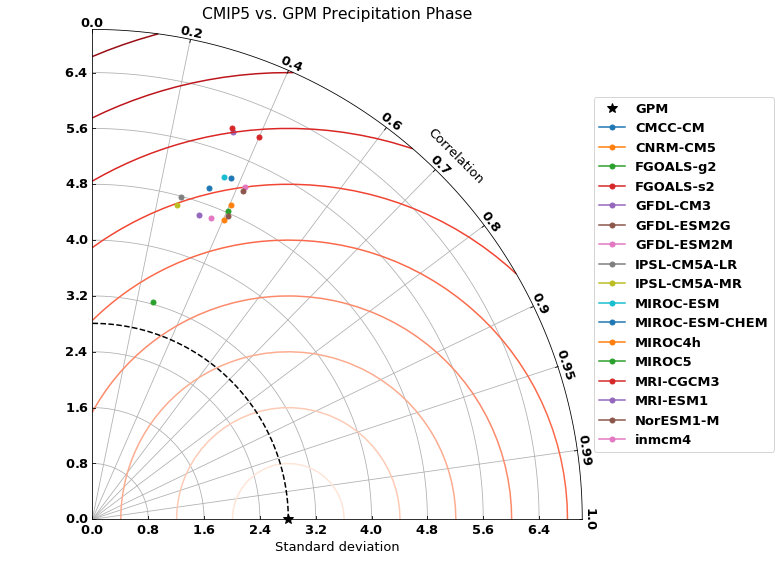

In [165]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM',
                                           srange=(0, 2.5))
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats.keys()):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats[model_name][0], 
                           corrcoef = model_error_stats[model_name][1], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1,0.5))

plt.title('CMIP5 vs. GPM Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5.png', dpi = 300)